In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline

In [2]:
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")
df.head(1).T

,0
recency,3.000000
history,977.510000
used_discount,1.000000
used_bogo,1.000000
is_referral,1.000000
treatment,0.000000
zip_code_Rural,0.000000
zip_code_Surburban,0.000000
zip_code_Urban,1.000000
channel_Multichannel,0.000000


In [4]:
# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

In [5]:

df['old_target'] = (df['target_class'] % 2).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25)

from sklearn.linear_model import LogisticRegression

Задание 1 из 2
Начнём с обучения S-learner на основе логистической регрессии. С помощью библиотеки Causal ML настройте автоматизацию обучения, которое ранее вы осуществляли вручную.

In [6]:
from causalml.inference.meta import BaseSClassifier

s_learner = BaseSClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
# оцените качество

In [7]:
uplift_vals

array([[0.06375855],
       [0.06572023],
       [0.06644343],
       ...,
       [0.04883641],
       [0.04192834],
       [0.07620716]])

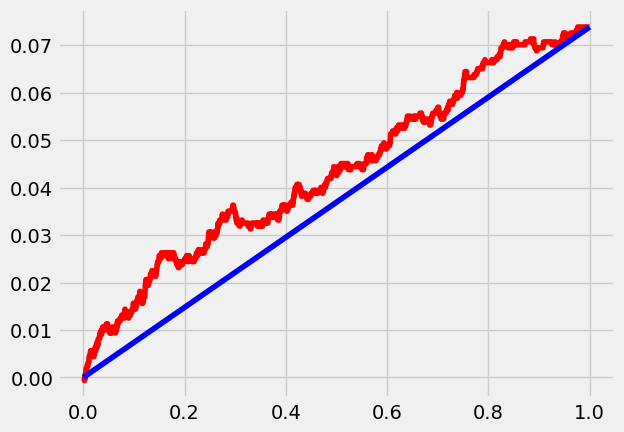

20.995829999999998

In [8]:
df_test["uplift_score"] = uplift_vals

# посчитаем Qini Score по нашему датасету
qini_df(df_test)

T-LEARNER

In [9]:
from causalml.inference.meta import BaseTClassifier

t_learner = BaseTClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))
# оцените качество

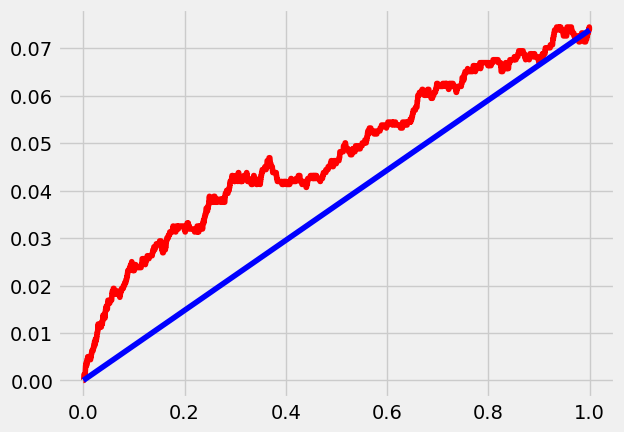

34.1297

In [10]:
# оцените качество
df_test["uplift_score"] = uplift_vals

# посчитаем Qini Score по нашему датасету
qini_df(df_test)